# Analysis of HCP behavioral dataset

Rekha Varrier, main analyses Nov 2020 - Jan 2021.
- Some of the results were presented in an OHBM 2021 and 2022 poster, and are now published in JNeuro November edition.


Note: every reference to "fullDat" was a parallel analysis performed without one of the exclusion criteria (removing trials with RT < 100ms) and was performed in response to a reviewer question.

Below are the steps to analyse the behavioral data of the HCP social task

In [1]:
#Importing data and packages, creating convenient variables
#%reset
import os
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
%matplotlib inline


folder = os.getcwd()
print('current dir: ',folder)
path = Path(folder)
parent_folder = path.parent
file_loc = os.path.join(parent_folder,'data')
print('data folder:',file_loc)
#old_dataFile  = os.path.join(file_loc,'hcp_social_behav_for_ddm_stim-coding.csv')
dataFile  = os.path.join(file_loc,'hcp_social_behav_for_ddm_stim-coding_corrected.csv')

current dir:  /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/code
data folder: /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data


In [2]:

vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

# read data and assign each row a run number based on the movie (movies were not randomized in the HCP study)
dat = pd.read_csv(dataFile)# , index_col = "subj_idx")
#dat_old = pd.read_csv(old_dataFile) # to compare with the old version
dat["run"] = ["run2" if x.split('.')[0] in vid_names["run1"] else "run1" for x in dat["movie"]]
dat["run"] = [0 if x.split('.')[0] in vid_names["run1"] else 1 for x in dat["movie"]]

print("n=",len(np.unique(dat["subj_idx"])))
dat.head(10) 

n= 1051


,subj_idx,stim,movie,rt,response,run
0,168745,Mental,Scaring.AVI,1.252,1,1
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1
2,168745,Random,STAR-A.AVI,1.643,0,1
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1
4,168745,Random,TENNIS-A.AVI,1.232,0,1
5,668361,Mental,COAXING-B.AVI,1.796,9,0
6,668361,Random,BILLIARD-A.AVI,1.254,0,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0
8,668361,Mental,Fishing.AVI,0.993,0,0
9,668361,Random,Random mechanical.AVI,0.816,0,0


In [3]:
# setting default fontsizes for plots
s=16 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'

In [ ]:
#print('ncorrected =:', dat.groupby(['movie']).count().subj_idx, '\n\ old:', dat_old.groupby(['movie']).count().subj_idx)

In [5]:
#add accuracy as an additional column
acc = np.zeros((dat.shape[0],)) -1 # initialize accuracy with -1
acc[((dat['stim'] == 'Mental') & (dat['response'] == 1)) | ((dat['stim'] == 'Random') & (dat['response'] == 0))] = 1
acc[((dat['stim'] == 'Mental') & (dat['response'] == 0)) | ((dat['stim'] == 'Random') & (dat['response'] == 1))] = 0
acc[dat['response'] == 9] = 9
dat['accuracy'] = acc

In [6]:
# exploring what happens if we don't exclude any trials based on RT.
allRTs = dat['rt'].values
print(allRTs[allRTs<=.1])
fullDat =  dat.loc[dat['rt']>=0,:]
fullDat.shape,dat.shape

[0.084 0.    0.03 ]


((10149, 7), (10149, 7))

- You will see that all of our analyses were also repeated on the full data without removing trials/subjects based on RTs (i.e., with 3 more trials from 3 distinct subs, i.e., 3 more subs). This was done to address a reviewer question. As you see below, there weren't any big differences, so we did not include the analysis with data that did not exclude trials based on RT (fullDat) in the manuscript

In [8]:
# remove imppossible RTs
rtmin = 0.1 # threshold for impossibly short RTs
print('nrows before=',dat.shape[0])
dat= dat.loc[dat['rt']>=rtmin,:]
print('nrows after=',dat.shape[0])
fullDat.shape,dat.shape

nrows before= 10149
nrows after= 10146


((10149, 7), (10146, 7))

In [9]:
# exclude bad subjects (with <10 yes/no/unsure responses)
thresh = 10
trial_counts = dat.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
dat  = dat.reset_index() # add index as an additional column "index"
dat = dat.set_index('subj_idx') # make subj_idx the index
dat.drop(bad_subs, inplace=True) # remove bad subjects
dat = dat.reset_index() #bring back subj_idx as a column
dat = dat.set_index('index') # make the column "index" as the index (as in the beginning)
print("Nr. of subjects left",len(dat.groupby("subj_idx")))
print("Nr. of rows:",dat.shape)

# the group not excluded based on RTs
trial_counts_fullDat = fullDat.groupby("subj_idx").count()["rt"]
bad_subs_fullDat = trial_counts_fullDat[(trial_counts_fullDat < thresh)].index
fullDat  = fullDat.reset_index() # add index as an additional column "index"
fullDat = fullDat.set_index('subj_idx') # make subj_idx the index
fullDat.drop(bad_subs_fullDat, inplace=True) # remove bad subjects
fullDat = fullDat.reset_index() #bring back subj_idx as a column
fullDat = fullDat.set_index('index') # make the column "index" as the index (as in the beginning)
print("Full data, Nr. of subjects left",len(fullDat.groupby("subj_idx")))
print("Full data, Nr. of rows:",fullDat.shape)

Nr. of subjects left 823
Nr. of rows: (8230, 7)
Full data, Nr. of subjects left 826
Full data, Nr. of rows: (8260, 7)


In [10]:
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

In [11]:
dat.to_csv(os.path.join(file_loc,'data_for_paper','hcp_social_826subs.csv')) # file name is wrong - there are only 823 subs actually
fullDat.to_csv(os.path.join(file_loc,'data_for_paper','fullDat_hcp_social_826subs.csv'))

In [12]:
#Sort into sure and unsure trials dfs
data_sure = dat[dat["response"]!=9]
data_unsure = dat[dat["response"] ==9]
print(len(np.unique(data_sure['subj_idx'])))

#Sort into sure and unsure trials dfs
data_sure_fullDat = fullDat[fullDat["response"]!=9]
data_unsure_fullDat = fullDat[fullDat["response"] ==9]
len(np.unique(data_sure_fullDat['subj_idx']))

823


826

In [22]:
# defining "bad" subs with lower thresholds - not used in the manuscript
#excluding bad subs: defined as those who have less than 'thresh' trials
# defined as 8/10 responses "sure", i.e., yes/no
# did this to make sure we have a good number of trials/subject - since our main analyses were only on the 
# sure trials

'''thresh = 8
trial_counts = data_sure.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
data_sure  = data_sure.reset_index() # add index as an additional column "index"
data_sure = data_sure.set_index('subj_idx') # make subj_idx the index
data_sure.drop(bad_subs, inplace=True) # remove bad subjects
data_sure = data_sure.reset_index() #bring back subj_idx as a column
data_sure = data_sure.set_index('index') # make the column "index" as the index (as in the beginning)

print("Nr. of subjects left",len(data_sure.groupby("subj_idx")))
print("Nr. of rows:",data_sure.shape)'''

'thresh = 8\ntrial_counts = data_sure.groupby("subj_idx").count()["rt"]\nbad_subs = trial_counts[(trial_counts < thresh)].index\n#print(bad_subs)\ndata_sure  = data_sure.reset_index() # add index as an additional column "index"\ndata_sure = data_sure.set_index(\'subj_idx\') # make subj_idx the index\ndata_sure.drop(bad_subs, inplace=True) # remove bad subjects\ndata_sure = data_sure.reset_index() #bring back subj_idx as a column\ndata_sure = data_sure.set_index(\'index\') # make the column "index" as the index (as in the beginning)\n\nprint("Nr. of subjects left",len(data_sure.groupby("subj_idx")))\nprint("Nr. of rows:",data_sure.shape)'

# 1(a) Number of responses per movie

In [23]:
movies_list = list(dat['movie'].values)
print(movies_list[:5])
dat['movies_ind']=[np.where(vid_joined==np.array(i[:-4]))[0][0] for i in movies_list]
dat.head()

['Scaring.AVI', 'SEDUCING-B.AVI', 'STAR-A.AVI', 'SURPRISING-B.AVI', 'TENNIS-A.AVI']


,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind
index,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9


In [24]:
movies_list_fullDat = list(fullDat['movie'].values)
fullDat['movies_ind']=[np.where(vid_joined==np.array(i[:-4]))[0][0] for i in movies_list_fullDat]
fullDat.head()

,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind
index,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9


In [25]:
counts = dat.groupby(['movies_ind','response']).count().subj_idx.unstack(level=-1)
counts[np.isnan(counts)] = 0
counts['sum'] = counts[0]+counts[1]+counts[9]
#counts = counts.sort_values(by=['movies_ind','response'])
#counts = counts.append({'movies_ind':8,'response':0,'subj_idx':0},ignore_index=True)
counts['socialness'] = counts[1]/counts['sum']
socialness = counts['socialness'].values
counts =  counts.sort_values(by=['socialness'])
counts

response,0,1,9,sum,socialness
movies_ind,,,,,
2,780.0,6.0,37.0,823.0,0.007290
1,778.0,11.0,34.0,823.0,0.013366
7,759.0,20.0,44.0,823.0,0.024301
9,691.0,35.0,97.0,823.0,0.042527
4,563.0,85.0,175.0,823.0,0.103281
3,58.0,698.0,67.0,823.0,0.848117
5,24.0,780.0,19.0,823.0,0.947752
6,5.0,802.0,16.0,823.0,0.974484
0,7.0,810.0,6.0,823.0,0.984204


In [26]:
counts_fullDat = fullDat.groupby(['movies_ind','response']).count().subj_idx.unstack(level=-1)
counts_fullDat[np.isnan(counts_fullDat)] = 0
counts_fullDat['sum'] = counts_fullDat[0]+counts_fullDat[1]+counts_fullDat[9]
#counts = counts.sort_values(by=['movies_ind','response'])
#counts = counts.append({'movies_ind':8,'response':0,'subj_idx':0},ignore_index=True)
counts_fullDat['socialness'] = counts_fullDat[1]/counts_fullDat['sum']
socialness_fullDat = counts_fullDat['socialness'].values
counts_fullDat =  counts_fullDat.sort_values(by=['socialness'])
counts_fullDat

response,0,1,9,sum,socialness
movies_ind,,,,,
2,782.0,6.0,38.0,826.0,0.007264
1,781.0,11.0,34.0,826.0,0.013317
7,761.0,20.0,45.0,826.0,0.024213
9,694.0,35.0,97.0,826.0,0.042373
4,564.0,86.0,176.0,826.0,0.104116
3,58.0,701.0,67.0,826.0,0.848668
5,24.0,783.0,19.0,826.0,0.947942
6,5.0,805.0,16.0,826.0,0.974576
0,7.0,813.0,6.0,826.0,0.984262


In [27]:
np.save(os.path.join(file_loc,'hcp_socialness.npy'),socialness)
np.save(os.path.join(file_loc,'hcp_socialness_fullDat.npy'),socialness_fullDat)

In [28]:
vid_joined

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [29]:
# prettify movie names by removing suffixes and renaming random mechanical
vid_movie_ticks = [str.upper(vid_joined[i].split('-')[0]) for i in counts.index] 
vid_movie_ticks[4] = 'RAND MECH'
vid_movie_ticks

['DRIFTING',
 'BILLIARD',
 'STAR',
 'TENNIS',
 'RAND MECH',
 'FISHING',
 'SCARING',
 'SEDUCING',
 'COAXING',
 'SURPRISING']

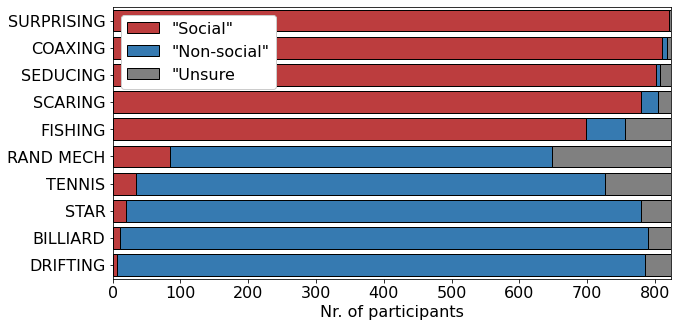

In [30]:
def plot_fig_1a(ax,counts):
    #function to plot figure 1a from the manuscript
    ax.barh(range(10),counts[1],color=red_rgb,label='"Social"',edgecolor='k')
    ax.barh(range(10),counts[0],left=counts[1],edgecolor='k',color=blue_rgb,label='"Non-social"')
    ax.barh(range(10),counts[9],left=counts[0]+counts[1],color='grey',edgecolor='k',label='"Unsure')

    ax.legend(loc='upper left',framealpha=1)
    #ax.legend(bbox_to_anchor=[1.01,1])
    ax.set_yticks(range(10))
    ax.set_yticklabels(vid_movie_ticks)
    ax.set_xlabel('Nr. of participants')
    #ax.set_title('Animations(least to most "Social")')
    ax.set_xlim(0,counts['sum'][0])
    ax.set_ylim(-.5,9.5)

fig = plt.figure(1,figsize=(10,5))
ax =  fig.add_subplot(111)
plot_fig_1a(ax,counts)

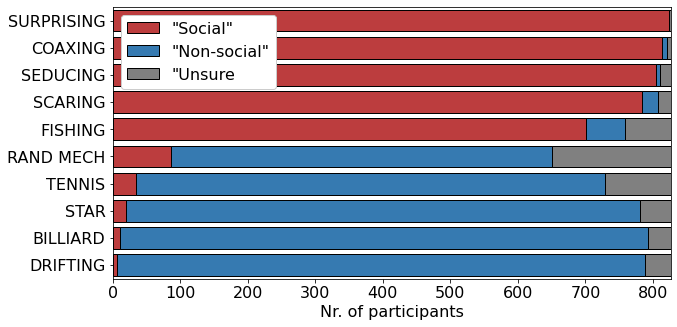

In [31]:
fig = plt.figure(1,figsize=(10,5))
ax =  fig.add_subplot(111)
plot_fig_1a(ax,counts_fullDat)

### 1(b) Number of yes/no responses per sub (for paper)

- to evaluate if there are more Yes ("Social" or 1) responses than No ("Non-social" or 0) responses on average - suggesting a Yes bias

In [32]:
counts_per_subj = data_sure.groupby(['subj_idx', 'response']).count().movie # Mean count per subject for Mental and Random
counts_per_subj = counts_per_subj.unstack(level = -1)
counts_per_subj['diff'] = counts_per_subj[1]-counts_per_subj[0]
counts_per_subj['sum'] = counts_per_subj[1]+counts_per_subj[0]
counts_per_subj

response,0,1,diff,sum
subj_idx,,,,
100206,1.0,9.0,8.0,10.0
100307,4.0,5.0,1.0,9.0
100408,4.0,5.0,1.0,9.0
100610,5.0,5.0,0.0,10.0
101309,2.0,5.0,3.0,7.0
...,...,...,...,...
991267,4.0,5.0,1.0,9.0
992673,5.0,5.0,0.0,10.0
992774,4.0,5.0,1.0,9.0


In [33]:
counts_per_subj_fullDat = data_sure_fullDat.groupby(['subj_idx', 'response']).count().movie # Mean count per subject for Mental and Random
counts_per_subj_fullDat = counts_per_subj_fullDat.unstack(level = -1)
counts_per_subj_fullDat['diff'] = counts_per_subj_fullDat[1]-counts_per_subj_fullDat[0]
counts_per_subj_fullDat['sum'] = counts_per_subj_fullDat[1]+counts_per_subj_fullDat[0]
counts_per_subj_fullDat

response,0,1,diff,sum
subj_idx,,,,
100206,1.0,9.0,8.0,10.0
100307,4.0,5.0,1.0,9.0
100408,4.0,5.0,1.0,9.0
100610,5.0,5.0,0.0,10.0
101309,2.0,5.0,3.0,7.0
...,...,...,...,...
991267,4.0,5.0,1.0,9.0
992673,5.0,5.0,0.0,10.0
992774,4.0,5.0,1.0,9.0


In [34]:
# identify NaNs (i.e., rows which either didn't have any 0s or 1s)
print(np.where(np.isnan(counts_per_subj)))
counts_per_subj.iloc[[60,181],:]

(array([ 60,  60,  60, 181, 181, 181]), array([0, 2, 3, 0, 2, 3]))


response,0,1,diff,sum
subj_idx,,,,
118528,NaN,9.0,NaN,NaN
153126,NaN,8.0,NaN,NaN


In [35]:
# identify NaNs (i.e., rows which either didn't have any 0s or 1s)
print(np.where(np.isnan(counts_per_subj_fullDat)))
counts_per_subj_fullDat.iloc[[62,183],:]

(array([ 62,  62,  62, 183, 183, 183]), array([0, 2, 3, 0, 2, 3]))


response,0,1,diff,sum
subj_idx,,,,
118528,NaN,9.0,NaN,NaN
153126,NaN,8.0,NaN,NaN


In [36]:
# relabel NaN
counts_per_subj.iloc[[60,181],0] = 0
counts_per_subj.iloc[[60,181],2] = counts_per_subj.iloc[[60,181],1]
counts_per_subj.iloc[[60,181],3] = counts_per_subj.iloc[[60,181],1]
counts_per_subj.iloc[[60,181],:]

counts_per_subj_fullDat.iloc[[62,183],0] = 0
counts_per_subj_fullDat.iloc[[62,183],2] = counts_per_subj_fullDat.iloc[[62,183],1]
counts_per_subj_fullDat.iloc[[62,183],3] = counts_per_subj_fullDat.iloc[[62,183],1]
counts_per_subj_fullDat.iloc[[62,183],:]

response,0,1,diff,sum
subj_idx,,,,
118528,0.0,9.0,9.0,9.0
153126,0.0,8.0,8.0,8.0


In [37]:
# exclude subs with 0 responses in social/nonsocial (extremes)
#rows = ~np.isnan(counts_per_subj['diff'])
#counts_per_subj = counts_per_subj.loc[rows,:]
counts_per_subj.shape, counts_per_subj_fullDat.shape

((823, 4), (826, 4))

In [ ]:
# compute response perceptages and theur diiference
counts_per_subj.loc[:,'No_pc']  = 100*counts_per_subj.loc[:,0]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Yes_pc'] = 100*counts_per_subj.loc[:,1]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Soc-NonSoc_pc'] = counts_per_subj.loc[:,'Yes_pc'] - counts_per_subj.loc[:,'No_pc']
#counts_per_subj

counts_per_subj_fullDat.loc[:,'No_pc']  = 100*counts_per_subj_fullDat.loc[:,0]/counts_per_subj_fullDat.loc[:,'sum']
counts_per_subj_fullDat.loc[:,'Yes_pc'] = 100*counts_per_subj_fullDat.loc[:,1]/counts_per_subj_fullDat.loc[:,'sum']
counts_per_subj_fullDat.loc[:,'Soc-NonSoc_pc'] = counts_per_subj_fullDat.loc[:,'Yes_pc'] - counts_per_subj_fullDat.loc[:,'No_pc']
#counts_per_subj_fullDat

In [39]:
counts_per_subj.mean(),counts_per_subj.sem()

(response
 0                 4.453220
 1                 4.941677
 diff              0.488457
 sum               9.394897
 No_pc            47.107803
 Yes_pc           52.892197
 Soc-NonSoc_pc     5.784393
 dtype: float64,
 response
 0                0.033162
 1                0.024413
 diff             0.051001
 sum              0.028113
 No_pc            0.290525
 Yes_pc           0.290525
 Soc-NonSoc_pc    0.581051
 dtype: float64)

In [40]:
counts_per_subj_fullDat.mean(),counts_per_subj_fullDat.sem()

(response
 0                 4.450363
 1                 4.943099
 diff              0.492736
 sum               9.393462
 No_pc            47.080259
 Yes_pc           52.919741
 Soc-NonSoc_pc     5.839483
 dtype: float64,
 response
 0                0.033185
 1                0.024358
 diff             0.050942
 sum              0.028179
 No_pc            0.290486
 Yes_pc           0.290486
 Soc-NonSoc_pc    0.580973
 dtype: float64)

25%:50.00, 50%:50.00, 75%:55.56
25%:44.44, 50%:50.00, 75%:50.0


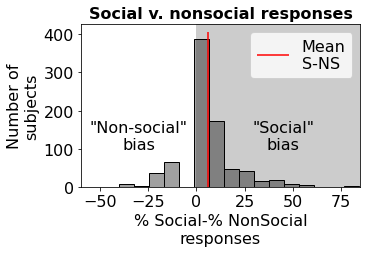

In [41]:
# informative figure, but not used in the paper
# NOT DONE FOR THE FULL DATA VERSION
fig = plt.figure(1,figsize=(5,3))
ax = fig.add_subplot(111)
sns.histplot(data=counts_per_subj,bins=20,x='Soc-NonSoc_pc',color='grey')
ax.set_xlabel('% Social-% NonSocial\nresponses')
ax.set_ylabel('Number of\nsubjects')
ymin,ymax = ax.get_ylim()
ax.vlines(counts_per_subj.mean()['Soc-NonSoc_pc'],ymin,ymax,color = 'r',label = 'Mean\nS-NS')
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.legend(loc='upper right')
ax.set_xlim(-60,85)
xmin,xmax = ax.get_ylim()
ax.axvspan(0,xmax, facecolor= '0', alpha=0.2) # background color for the first 5 bars(mental?)
ax.axvspan(xmin,0, facecolor='0.1', alpha=0.2) # background color for the first 5 bars(mental?)

ax.text(-30,100,'"Non-social"\nbias', ha='center', color = 'black')
ax.text(45,100,'"Social"\nbias', ha='center', color = 'black')
ax.set_title("Social v. nonsocial responses",fontweight='bold')
stats.ttest_1samp(counts_per_subj['Soc-NonSoc_pc'], 0)

print(f"25%:{np.quantile(counts_per_subj['Yes_pc'],.25):.2f}, 50%:{np.quantile(counts_per_subj['Yes_pc'],.5):.2f}, 75%:{np.quantile(counts_per_subj['Yes_pc'],.75):.2f}")
print(f"25%:{np.quantile(counts_per_subj['No_pc'],.25):.2f}, 50%:{np.quantile(counts_per_subj['No_pc'],.5):.2f}, 75%:{np.quantile(counts_per_subj['No_pc'],.75)}")

In [42]:
def box_plot(data, edge_color, fill_color,pos,v):
    # code to customize boxplots

    alpha= .2
    bp = ax.boxplot(data, positions = [pos], patch_artist=True,widths=.5,vert=v,flierprops = dict(markeredgecolor=edge_color,
    markerfacecolor=fill_color, alpha=alpha))
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for element in ['medians']:
        plt.setp(bp[element], color='k',linewidth=2,ls='dashed')
    #for element in ['fliers']:
    #    plt.setp(bp[element], marker= (5,2,0))#'*')

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha=alpha)#'w'
    return bp

# exploring colors 
#import matplotlib.cm
#for i in range(len(matplotlib.cm.datad["RdBu"])):
#    print(np.array(matplotlib.cm.datad["RdBu"][i])*255)
#red_rgb = np.array(matplotlib.cm.datad["RdBu"][0])*255
#blue_rgb = np.array(matplotlib.cm.datad["RdBu"][-1])*255
#print('red:',red_rgb,',\n blue:',blue_rgb)

- asterisks convention:
- p <.05: *
- p < .01 **
- p < .001 ***
- p > .05 but  <.1 +

mean diff: 5.7843931416227905
Ttest_relResult(statistic=-9.955057612909297, pvalue=4.0348763675618627e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


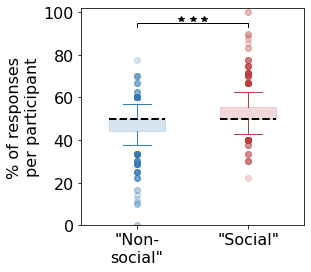

In [43]:
def plot_fig_1b(ax,counts_per_subj):
    #function to plot figure 1b from the manuscript
    
    bp1 = box_plot(counts_per_subj['Yes_pc'], red_rgb, red_rgb,1,True)
    bp2 = box_plot(counts_per_subj['No_pc'], blue_rgb, blue_rgb,0,True)
    plt.xticks(range(2),['"Non-\nsocial"','"Social"'])
    plt.ylabel("% of responses\nper participant")
    plt.ylim(0,102)
    plt.yticks([0,20,40,60,80,100])
    xmin,xmax = plt.xlim()
    plt.xlabel('')
    plt.plot([0,0,1,1],[93,95,95,93],linewidth = 1,color='k')
    plt.plot([0.4,0.5,0.6],[97]*3,'*',color='k')
    print('mean diff:',np.nanmean(counts_per_subj['Yes_pc']-counts_per_subj['No_pc']))
    print(stats.ttest_rel(counts_per_subj['No_pc'],counts_per_subj['Yes_pc']))
    print('when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!')

fig = plt.figure(figsize=(4,4))
ax =  fig.add_subplot(111)
plot_fig_1b(ax,counts_per_subj)

mean diff: 5.839482685729659
Ttest_relResult(statistic=-10.0512171700471, pvalue=1.680706301406872e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


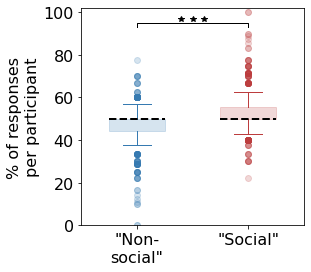

In [44]:
fig = plt.figure(figsize=(4,4))
ax =  fig.add_subplot(111)
plot_fig_1b(ax,counts_per_subj_fullDat)

In [45]:
# save data for trait analysis etc
counts_per_subj = counts_per_subj.rename(columns={0: 'countNonSoc(No)', 1: 'countSoc(Yes)','diff':'Yes-No','sum':'Yes+No'})
#counts_per_subj

# save data for trait analysis etc
counts_per_subj_fullDat = counts_per_subj_fullDat.rename(columns={0: 'countNonSoc(No)', 1: 'countSoc(Yes)','diff':'Yes-No','sum':'Yes+No'})
#counts_per_subj_fullDat

response,countNonSoc(No),countSoc(Yes),Yes-No,Yes+No,No_pc,Yes_pc,Soc-NonSoc_pc
subj_idx,,,,,,,
100206,1.0,9.0,8.0,10.0,10.000000,90.000000,80.000000
100307,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100408,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100610,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
101309,2.0,5.0,3.0,7.0,28.571429,71.428571,42.857143
...,...,...,...,...,...,...,...
991267,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
992673,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
992774,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111


In [46]:
counts_per_subj.to_csv(os.path.join(file_loc,'data_for_paper','1b_S_NS_responses_per_subj.csv'))
counts_per_subj_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1b_S_NS_responses_per_subj_fullDat.csv'))

## 1(c) SDT estimates for our data

- in addition to counting one or the other responses, we can also use signal detection measures to see how they align with experimenter-assigned labels. For example, a higher number of "social" responses could show in a net(1) response bias towards social, and/or (2) an decrease in d prime (?)

In [47]:
# Function to compute SDT measures like dprime, critia etc. 

from scipy.stats import norm
import math
Z = norm.ppf
 
def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)
 
    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))
    
    return(out)

In [48]:
#creating a matrix of hits, FAs, FNs and CRs per subject

matrix = data_sure.groupby(["subj_idx", "stim"])["response"].value_counts().unstack().fillna(0) #/n_trials
#matrix.head(10)

matrix_fullDat = data_sure_fullDat.groupby(["subj_idx", "stim"])["response"].value_counts().unstack().fillna(0) #/n_trials
#matrix_fullDat.head(10)

response           0    1
subj_idx stim            
100206   Mental  0.0  5.0
         Random  1.0  4.0
100307   Mental  0.0  4.0
         Random  4.0  1.0
100408   Mental  0.0  5.0
         Random  4.0  0.0
100610   Mental  0.0  5.0
         Random  5.0  0.0
101309   Mental  0.0  5.0
         Random  2.0  0.0

In [ ]:
hits = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[1] # '1' responses for Mental
misses = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[0] # '0' responses for Mental
false_alarms = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[1]
correct_rejects = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[0]

hits.name='hits'
misses.name='misses'
false_alarms.name='false_alarms'
correct_rejects.name='correct_rejects'

sdt_data = pd.concat([hits, misses, false_alarms, correct_rejects], axis=1)
#sdt_data.head()
#sdt_data.transpose().plot(legend = None, alpha = 0.1)

hits_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Mental"].reset_index("stim")[1] # '1' responses for Mental
misses_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Mental"].reset_index("stim")[0] # '0' responses for Mental
false_alarms_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Random"].reset_index("stim")[1]
correct_rejects_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Random"].reset_index("stim")[0]

hits_fullDat.name='hits'
misses_fullDat.name='misses'
false_alarms_fullDat.name='false_alarms'
correct_rejects_fullDat.name='correct_rejects'

sdt_data_fullDat = pd.concat([hits_fullDat, misses_fullDat, false_alarms_fullDat, correct_rejects_fullDat], axis=1)
#sdt_data_fullDat.head()
#sdt_data.transpose().plot(legend = None, alpha = 0.1)

In [ ]:
# extracting SDT measures for each subject and saving in a dataframe
results = {}
for s, subj in enumerate(sdt_data.index.values):
    results[subj] = SDT(sdt_data["hits"].iloc[s], sdt_data["misses"].iloc[s], sdt_data["false_alarms"].iloc[s], sdt_data["correct_rejects"].iloc[s])

sdt_measures = pd.DataFrame.from_dict(results, orient="index")
#sdt_measures.head()

results_fullDat = {}
for s, subj in enumerate(sdt_data_fullDat.index.values):
    results_fullDat[subj] = SDT(sdt_data_fullDat["hits"].iloc[s], sdt_data_fullDat["misses"].iloc[s], \
        sdt_data_fullDat["false_alarms"].iloc[s], sdt_data_fullDat["correct_rejects"].iloc[s])

sdt_measures_fullDat = pd.DataFrame.from_dict(results_fullDat, orient="index")
#sdt_measures_fullDat.head()

dat
mean: 2.3269282788643113 , sem: 0.012587219730840642
339076.0 , 6.663292598494334e-140
full dat
mean: 2.3265185118054186 ,sem: 0.012555199944471952
341551.0 , 2.1581726642417955e-140


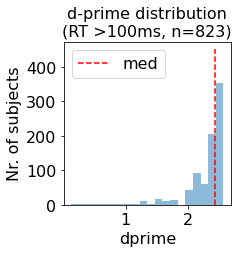

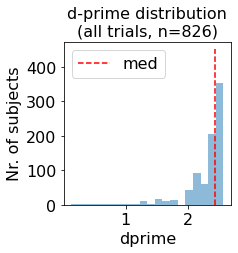

In [57]:
# Plotting the distributions of dprimes and criteria across subjects
# d-prime values not used in the paper, but for the reviewer in revision 1

plt.figure(1,figsize =(3,3))
sdt_measures['d'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures['d']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('d-prime distribution\n(RT >100ms, n=823)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("dprime")
plt.legend()

print('dat\nmean:', sdt_measures['d'].mean(), ', sem:', sdt_measures['d'].sem()) # for the reviewer in revision 1
std,pdprime = stats.wilcoxon(sdt_measures['d'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pdprime)

plt.figure(2,figsize =(3,3))
sdt_measures_fullDat['d'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures_fullDat['d']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('d-prime distribution\n(all trials, n=826)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("dprime")
plt.legend()

print('full dat\nmean:',sdt_measures_fullDat['d'].mean(), ',sem:', sdt_measures_fullDat['d'].sem()) # for the reviewer in revision 1
std,pdprime = stats.wilcoxon(sdt_measures_fullDat['d'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pdprime)


In [78]:
sdt_measures['beta-1'] = sdt_measures['beta'] - 1 
sdt_measures_fullDat['beta-1'] = sdt_measures_fullDat['beta'] - 1 

dat
mean: 0.9545053541793677 , sem: 0.008846875340468362
339076.0 , 4.4562663326571415e-140
dat
mean: 0.9536768051715554 , sem: 0.008837223845901677
341551.0 , 1.441437161773569e-140


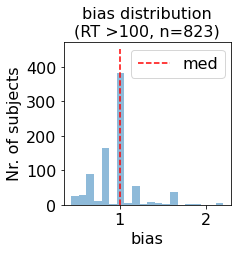

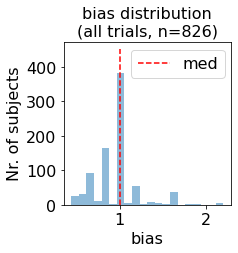

In [58]:
# for reviewer 2 in revision 1
plt.figure(1,figsize =(3,3))
sdt_measures['beta'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures['beta']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('bias distribution\n(RT >100, n=823)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("bias")
plt.legend(bbox_to_anchor = [1.01,1])
plt.savefig('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/revision1/bias_823.png',dpi=300,bbox_inches='tight',facecolor='w')

print('dat\nmean:', sdt_measures['beta'].mean(), ', sem:', sdt_measures['beta'].sem()) # for the reviewer in revision 1
std,pbeta = stats.wilcoxon(sdt_measures['beta'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pbeta)

# for reviewer 2 in revision 1
plt.figure(2,figsize =(3,3))
sdt_measures_fullDat['beta'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures_fullDat['beta']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('bias distribution\n(all trials, n=826)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("bias")
plt.legend(bbox_to_anchor = [1.01,1])
plt.savefig('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/revision1/bias_all.png',dpi=300,bbox_inches='tight',facecolor='w')

print('dat\nmean:', sdt_measures_fullDat['beta'].mean(), ', sem:', sdt_measures_fullDat['beta'].sem()) # for the reviewer in revision 1
std,pbeta = stats.wilcoxon(sdt_measures_fullDat['beta'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pbeta)

In [95]:
stats.wilcoxon(sdt_measures['beta'], np.ones((sdt_measures.shape[0],))) # non parametric alternative to one-sample ttest

WilcoxonResult(statistic=35263.0, pvalue=1.1813177242431023e-08)

In [92]:
stats.wilcoxon(sdt_measures_fullDat['beta'], np.ones((sdt_measures_fullDat.shape[0],))) # non parametric alternative to one-sample ttest

WilcoxonResult(statistic=35360.0, pvalue=6.930161198437038e-09)

In [208]:
sdt_measures_fullDat['c'].mean(), sdt_measures_fullDat['c'].sem() # for revision 1

(-0.047499453931695565, 0.005924944659365216)

26813.5 , 1.0623685894361655e-18 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


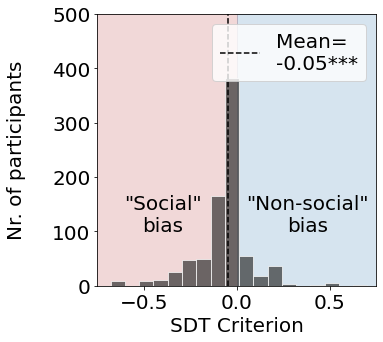

In [210]:
def plot_fig_1c(ax,sdt_measures):
    # Figure 1c in the paper

    stc, pc = stats.wilcoxon(sdt_measures['c'])
    print(stc,',',pc, 'when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!')

    ax.axvspan(-1,0,color=red_rgb,alpha=alpha)
    ax.axvspan(0,1,color=blue_rgb,alpha=alpha)
    sdt_measures['c'].hist(bins=25, alpha = .7, color = [.2,.2,.2],edgecolor = 'white')
    ax.vlines(np.nanmean(sdt_measures['c']),0,500,color='k', linestyle = 'dashed',
            label = f"Mean=\n{np.round(np.nanmean(sdt_measures['c']),2)}***")# \n"r"(p<$10^{-18}$)"

    ax.grid(None)
    ax.set_ylabel('Nr. of participants\n ')
    ax.set_xlabel("SDT Criterion")
    ax.set_xlim(-.75,.75)
    ax.set_ylim(0,500)
    #plt.xticks([-.75,-.5,-.25,0,.25,.5,.75], rotation=30)
    #plt.legend(fontsize = 14,bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.legend()#bbox_to_anchor = (1.05,1))

    ax.text(-.4,100,'"Social"\nbias', ha='center',  color = 'k')
    ax.text(.38,100,'"Non-social"\nbias', ha='center', color = 'k')

    #plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)
plot_fig_1c(ax,sdt_measures)

26834.0 , 4.435764321171681e-19 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


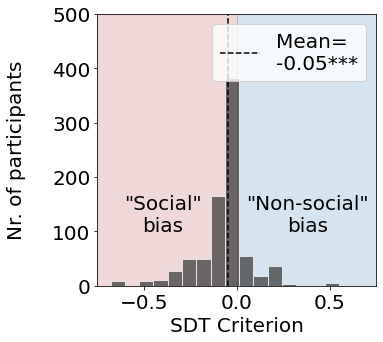

In [211]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)
plot_fig_1c(ax,sdt_measures_fullDat)

In [114]:
# save data for trait analysis etc
sdt_measures.to_csv(os.path.join(file_loc,'data_for_paper','1c_SDTmeasures_per_subj.csv'))
sdt_measures_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1c_SDTmeasures_per_subj_fulldata.csv'))

# LMEMs for the trial-level analyses (Response time and unure responses - Figures 1d and 1e in the manuscript)

In [115]:
# LMEM: We use the Python version called pymer4 of the R package lme4.
# from pymer4.test_install import test_install; test_install() # to test pyme4r install
# important: pymer installed in the conda environment py37 (python v3.7x), 
# so if module can't be found here, quit Jupyter and type 'conda activate py37' into terminal

#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm

- Subject and stimulus being random factors that could've influenced results, it's important to control for them. LMEM lets us control for their effects on the DV using random intercepts and sometimes also on how the regressors affect the DV (using random slopes). The following cells show various LMEMs.

Interpreting the logistic regression results : if coef= .379
log(p(r=1)/p(r=0)) = .379 So p(r=1)/p(r=0) = exp(.379) > 1, so p(r=1) is more likely, BUT p-value = 0.749 so results are not significant.

## Reaction time

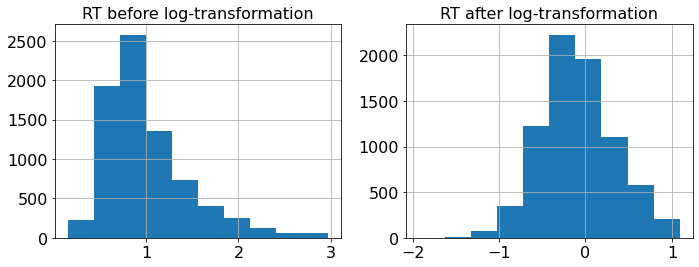

In [116]:
#log-transforming RT makes the distribution closer to a Gaussian (and its residuals too - which is an assumption in LMEMs)

data_sure = data_sure.assign(logRT = np.log(data_sure['rt'])) # add a column for logRT
data_sure.head()

plt.figure(1, figsize=(10,4))
plt.subplot(1,2,1)
plt.title("RT before log-transformation")
data_sure['rt'].hist()
plt.subplot(1,2,2)
plt.title("RT after log-transformation")
data_sure['logRT'].hist()
plt.tight_layout()

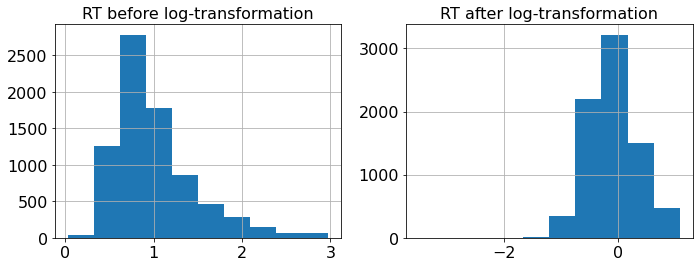

In [130]:
# same as above, but for the fullData
data_sure_fullDat.loc[data_sure_fullDat['rt']==0,'rt'] = np.nan
data_sure_fullDat = data_sure_fullDat.assign(logRT = np.log(data_sure_fullDat['rt'])) # add a column for logRT
data_sure_fullDat.head()

plt.figure(1, figsize=(10,4))
plt.subplot(1,2,1)
plt.title("RT before log-transformation")
data_sure_fullDat['rt'].hist()
plt.subplot(1,2,2)
plt.title("RT after log-transformation")
data_sure_fullDat['logRT'].hist()
plt.tight_layout()

- Most of the analyses will be done on the sure responses.
- RT is skewed and hence we take its log-transform (still not fully normal)

## Qn: Are "social" responses faster than "nonsocial" responses?

- asterisks convention:
- p <.05: *
- p < .01 **
- p < .001 ***
- p > .05 but  <.1 +

Observer responses as labels:
test stat= 144885.0 , p= 0.0005566263911873042


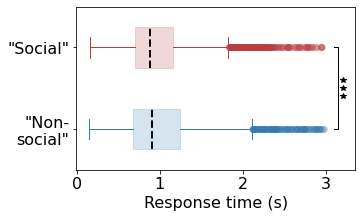

In [132]:
def plot_fig_1d(ax, p_rt):
    # Figure 1d in the manuscript

    bp1 = box_plot(data_sure.loc[data_sure['response']==1,'rt'], red_rgb, red_rgb,1,False)
    bp2 = box_plot(data_sure.loc[data_sure['response']==0,'rt'], blue_rgb, blue_rgb,0,False)
    ax.set_yticks(range(2))
    ax.set_yticklabels(('"Non-\nsocial"','"Social"'))
    ax.set_ylabel('')
    ax.set_xlabel('Response time (s)')
    ax.plot([3.1,3.15,3.15,3.1],[0,0,1,1],color='k', linewidth=1)

    if p_rt < .001:
        plt.plot([3.2]*3,[.5,.4,.6],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt < .01:
        plt.plot([3.2]*2,[.45,.55],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt < .05:
        plt.plot([3.2]*1,[.5],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3#return rts_per_subj

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj = data_sure.groupby(['subj_idx', 'response']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj['diff'] = rts_per_subj[1]-rts_per_subj[0]

rts_per_subj.dropna(inplace=True) # remove NaN rows
rts_per_subj = rts_per_subj.rename(columns={0: 'medianRT_NonSoc(No)', 1: 'medianRT_Soc(Yes)','diff':'medianYes-medianNo'})
st_rt, p_rt = stats.wilcoxon(rts_per_subj['medianRT_Soc(Yes)'],rts_per_subj['medianRT_NonSoc(No)'])#rts_per_subj['diff'])
print('Observer responses as labels:\ntest stat=',st_rt,', p=',p_rt)

plot_fig_1d(ax, p_rt)


In [217]:
rts_per_subj.median(), rts_per_subj.sem()

(response
 medianRT_NonSoc(No)    0.900
 medianRT_Soc(Yes)      0.870
 medianYes-medianNo    -0.023
 dtype: float64,
 response
 medianRT_NonSoc(No)    0.011850
 medianRT_Soc(Yes)      0.009195
 medianYes-medianNo     0.011437
 dtype: float64)

Observer responses as labels:
test stat= 145488.0 , p= 0.00042281593662054994


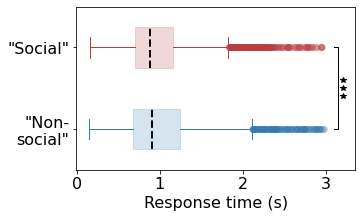

In [134]:
# RT analysis on the full data
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj_fullDat = data_sure_fullDat.groupby(['subj_idx', 'response']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj_fullDat['diff'] = rts_per_subj_fullDat[1]-rts_per_subj_fullDat[0]

rts_per_subj_fullDat.dropna(inplace=True) # remove NaN rows
rts_per_subj_fullDat = rts_per_subj_fullDat.rename(columns={0: 'medianRT_NonSoc(No)', 1: 'medianRT_Soc(Yes)','diff':'medianYes-medianNo'})
st_rt_fullDat, p_rt_fullDat = stats.wilcoxon(rts_per_subj_fullDat['medianRT_Soc(Yes)'],rts_per_subj_fullDat['medianRT_NonSoc(No)'])#rts_per_subj['diff'])
print('Observer responses as labels:\ntest stat=',st_rt_fullDat,', p=',p_rt_fullDat)

plot_fig_1d(ax, p_rt_fullDat)

In [218]:
rts_per_subj_fullDat.median(),rts_per_subj_fullDat.sem()

(response
 medianRT_NonSoc(No)    0.9005
 medianRT_Soc(Yes)      0.8695
 medianYes-medianNo    -0.0230
 dtype: float64,
 response
 medianRT_NonSoc(No)    0.011816
 medianRT_Soc(Yes)      0.009173
 medianYes-medianNo     0.011414
 dtype: float64)

Experimenter labels:
test stat= 142604.0 , p= 0.00012223828267660035


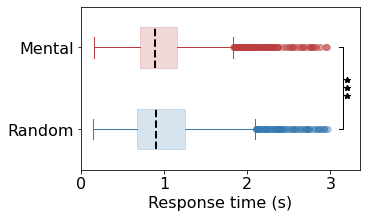

In [135]:
def plot_fig_1d_MentalRandom(ax,p_rt_MentalRandom):
    # repeating figure 1d but for Mental vs. Random (experimenter label-based) comparisons. 

    bp1 = box_plot(data_sure.loc[data_sure['stim']=='Mental','rt'], red_rgb, red_rgb,1,False)
    bp2 = box_plot(data_sure.loc[data_sure['stim']=='Random','rt'], blue_rgb, blue_rgb,0,False)

    ax.set_yticks(range(2))
    ax.set_yticklabels(('Random','Mental'))
    ax.set_ylabel('')
    ax.set_xlabel('Response time (s)')
    ax.plot([3.1,3.15,3.15,3.1],[0,0,1,1],color='k', linewidth=1)

    if p_rt_MentalRandom < .001:
        plt.plot([3.2]*3,[.5,.4,.6],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt_MentalRandom < .01:
        plt.plot([3.2]*2,[.45,.55],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt_MentalRandom < .05:
        plt.plot([3.2]*1,[.5],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3#return rts_per_subj


    plt.plot([3.2]*3,[.5,.4,.6],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj_MentalRandom = data_sure.groupby(['subj_idx', 'stim']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj_MentalRandom['diff'] = rts_per_subj_MentalRandom['Mental']-rts_per_subj_MentalRandom['Random']

rts_per_subj_MentalRandom.dropna(inplace=True) # remove NaN rows
rts_per_subj_MentalRandom = rts_per_subj_MentalRandom.rename(columns={'Random': 'medianRT_Random', 'Mental': 'medianRT_Mental','diff':'medianMental-medianRandom'})
st_rt_MentalRandom, p_rt_MentalRandom = stats.wilcoxon(rts_per_subj_MentalRandom['medianRT_Mental'],rts_per_subj_MentalRandom['medianRT_Random'])#rts_per_subj['diff'])
print('Experimenter labels:\ntest stat=',st_rt_MentalRandom,', p=',p_rt_MentalRandom)

plot_fig_1d_MentalRandom(ax,p_rt_MentalRandom)

Experimenter labels:
test stat= 143352.0 , p= 9.949081293607178e-05


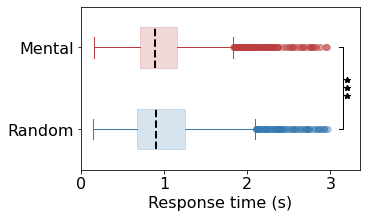

In [137]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj_MentalRandom_fullDat = data_sure_fullDat.groupby(['subj_idx', 'stim']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj_MentalRandom_fullDat['diff'] = rts_per_subj_MentalRandom_fullDat['Mental']-rts_per_subj_MentalRandom_fullDat['Random']

rts_per_subj_MentalRandom_fullDat.dropna(inplace=True) # remove NaN rows
rts_per_subj_MentalRandom_fullDat = rts_per_subj_MentalRandom_fullDat.rename(columns={'Random': 'medianRT_Random', 'Mental': 'medianRT_Mental','diff':'medianMental-medianRandom'})
st_rt_MentalRandom_fullDat, p_rt_MentalRandom_fullDat = stats.wilcoxon(rts_per_subj_MentalRandom_fullDat['medianRT_Mental'],rts_per_subj_MentalRandom_fullDat['medianRT_Random'])#rts_per_subj['diff'])
print('Experimenter labels:\ntest stat=',st_rt_MentalRandom_fullDat,', p=',p_rt_MentalRandom_fullDat)

plot_fig_1d_MentalRandom(ax,p_rt_MentalRandom_fullDat)


In [216]:
rts_per_subj_MentalRandom.mean()

stim
medianRT_Mental              0.916100
medianRT_Random              0.967869
medianMental-medianRandom   -0.051769
dtype: float64

In [139]:
# identify NaN rows
print(np.where(np.isnan(rts_per_subj_MentalRandom)))
print(rts_per_subj_MentalRandom.iloc[[60,181],:])
rts_per_subj_MentalRandom.shape

#print(st_rt,',',p_rt,np.nanmean(rts_per_subj_MentalRandom['medianMental-medianRandom']))
#rts_per_subj_MentalRandom.median(),rts_per_subj_MentalRandom.sem()

(array([], dtype=int64), array([], dtype=int64))
stim      medianRT_Mental  medianRT_Random  medianMental-medianRandom
subj_idx                                                             
118528              0.856           1.2375                    -0.3815
153126              0.859           0.7720                     0.0870


(823, 3)

- so overall, there's no difference between Mental/Random and Social/Non-social above

In [144]:
# save data for trait analysis etc
data_sure.to_csv(os.path.join(file_loc,'data_for_paper','1d_sure_responses.csv'),index=False)
data_sure_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1d_sure_responses_fullDat.csv'),index=False)
rts_per_subj.to_csv(os.path.join(file_loc,'data_for_paper','extra_medianRT_per_subj.csv'))
rts_per_subj_MentalRandom.to_csv(os.path.join(file_loc,'data_for_paper','extra_medianRT_per_subj_MentalRandom.csv'))

## RT data analysis using LMEMs

Formula: logRT~response+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7732	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -3117.835 	 AIC: 6235.670

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.029  0.171
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.066  -0.176    0.044  0.056    10.126  -1.175  0.267    
response       -0.037  -0.081    0.008  0.023  3509.453  -1.626  0.104    


NormaltestResult(statistic=287.54123357855724, pvalue=3.6409479346292417e-63)

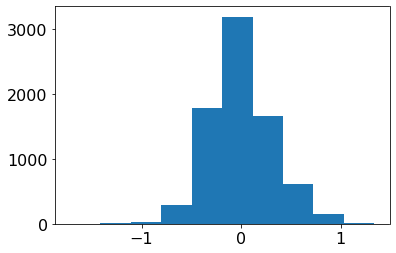

In [147]:
# USED IN THE PAPER!!
model = Lmer('logRT ~  response +(1|subj_idx) + (1|movie)', data=data_sure)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

In [150]:
data_sure_fullDat_nonan = data_sure_fullDat.loc[~np.isnan(data_sure_fullDat['rt']),:]
data_sure_fullDat_nonan.shape,data_sure_fullDat.shape

((7758, 8), (7759, 8))

Formula: logRT~response+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7758	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -3205.671 	 AIC: 6411.343

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.029  0.170
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.065  -0.175    0.044  0.056    10.150  -1.172  0.268    
response       -0.040  -0.085    0.005  0.023  3415.352  -1.755  0.079   .


NormaltestResult(statistic=472.27147664442975, pvalue=2.8025403008216897e-103)

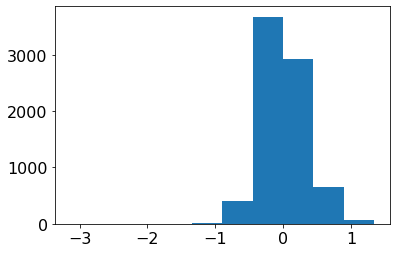

In [152]:
model = Lmer('logRT ~  response +(1|subj_idx) + (1|movie)', data=data_sure_fullDat_nonan)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit())
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~stim+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7732	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -3117.557 	 AIC: 6235.114

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.033  0.181
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
(Intercept)    -0.079  -0.238    0.081  0.081  8.129  -0.966  0.362    
stim1          -0.012  -0.237    0.213  0.115  8.002  -0.103  0.920    


NormaltestResult(statistic=287.7385573507574, pvalue=3.298877249791852e-63)

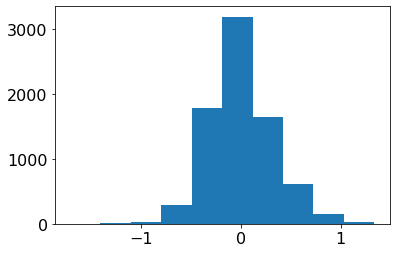

In [153]:
# in preparing to respond to the first revision, repeat model with stimtype 
model = Lmer('logRT ~  stim +(1|subj_idx) + (1|movie)', data=data_sure)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= modelb
# .data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~stim+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7758	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -3205.622 	 AIC: 6411.245

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.032  0.180
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
(Intercept)    -0.079  -0.238     0.08  0.081  8.130  -0.975  0.357    
stim1          -0.014  -0.237     0.21  0.114  8.002  -0.118  0.909    


NormaltestResult(statistic=472.12339452121074, pvalue=3.0179183866444107e-103)

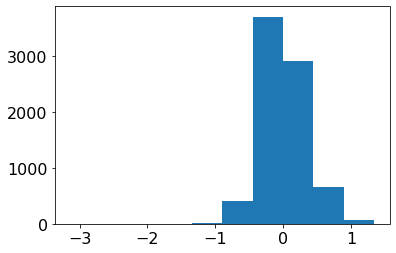

In [154]:
# in preparing to respond to the first revision, repeat model with stimtype 

model = Lmer('logRT ~  stim +(1|subj_idx) + (1|movie)', data=data_sure_fullDat_nonan)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= modelb
# .data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

## Uncertainty analyses (Figure 1e in manuscript)

In [171]:
certainty = np.ones(len(dat['response']))
certainty = [1 if i != 9 else 0 for i in dat['response'].values]
dat['certainty'] = certainty
uncertainty = [0 if i != 9 else 1 for i in dat['response'].values]
dat['uncertainty'] = uncertainty
#dat = dat.assign(certainty)
dat.head(10)

,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind,certainty,uncertainty
index,,,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5,1,0
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6,1,0
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7,1,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8,1,0
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9,1,0
5,668361,Mental,COAXING-B.AVI,1.796,9,0,9.0,0,0,1
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0,1,1,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0,2,1,0
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0,3,1,0


In [172]:
certainty_fullDat = np.ones(len(fullDat['response']))
certainty_fullDat = [1 if i != 9 else 0 for i in fullDat['response'].values]
fullDat['certainty'] = certainty_fullDat
uncertainty_fullDat = [0 if i != 9 else 1 for i in fullDat['response'].values]
fullDat['uncertainty'] = uncertainty_fullDat
#dat = dat.assign(certainty)
fullDat.head(10)

,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind,certainty,uncertainty
index,,,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5,1,0
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6,1,0
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7,1,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8,1,0
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9,1,0
5,668361,Mental,COAXING-B.AVI,1.796,9,0,9.0,0,0,1
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0,1,1,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0,2,1,0
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0,3,1,0


before: (823, 2)
after: (823, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


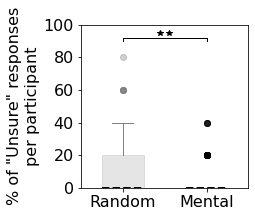

In [173]:
def plot_fig_1e(ax,summary):
    # figure 1e in the manuscript
    cols = summary.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    summary = summary[cols]
    print('before:',summary.shape)
    summary = summary.loc[(~np.isnan(summary['Random'])&(~np.isnan(summary['Mental']))),:]
    print('after:',summary.shape)
    mn = summary.mean()
    sem = summary.sem()

    bp1 = box_plot(summary['Random'], 'grey', 'grey',0,True)
    bp2 = box_plot(summary['Mental'], 'black', 'black',1,True)

    plt.xticks((0,1),('Random','Mental'))
    plt.xlabel('')
    plt.ylabel('% of "Unsure" responses\nper participant')
    plt.ylim(0,100)

    plt.plot([0,0,1,1],[90,92,92,90],color='k',linewidth=1)
    plt.plot([0.45,0.55],[95,95],'*',color='k')
    print(f"Mental: 25%:{np.quantile(summary['Mental'],.25):.2f}, 50%:{np.quantile(summary['Mental'],.5):.2f}, 75%:{np.quantile(summary['Mental'],.75):.2f}")
    print(f"Random: 25%:{np.quantile(summary['Random'],.25):.2f}, 50%:{np.quantile(summary['Random'],.5):.2f}, 75%:{np.quantile(summary['Random'],.75):.2f}")
    return summary
    
summary = 100*dat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary.shape
fig = plt.figure(1,figsize = (3,3))
ax = fig.add_subplot(111)
summary = plot_fig_1e(ax,summary)


before: (826, 2)
after: (826, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


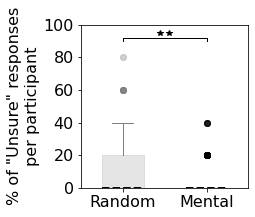

In [174]:
summary_fullDat = 100*fullDat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary_fullDat.shape
fig = plt.figure(1,figsize = (3,3))
ax = fig.add_subplot(111)
summary_fullDat = plot_fig_1e(ax,summary_fullDat)

In [185]:
summary1 = summary.rename(columns={'Random': 'pc_unc_Rand', 'Mental': 'pc_unc_Mental'})
summary1.mean(),summary1.sem()

(stim
 pc_unc_Rand      9.404617
 pc_unc_Mental    2.697448
 dtype: float64,
 stim
 pc_unc_Rand      0.502480
 pc_unc_Mental    0.259658
 dtype: float64)

In [186]:
summary1_fullDat = summary_fullDat.rename(columns={'Random': 'pc_unc_Rand', 'Mental': 'pc_unc_Mental'})
summary1_fullDat.mean(),summary1_fullDat.sem()

(stim
 pc_unc_Rand      9.443099
 pc_unc_Mental    2.687651
 dtype: float64,
 stim
 pc_unc_Rand      0.504647
 pc_unc_Mental    0.258776
 dtype: float64)

Formula: uncertainty~stim+(1|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8230	 Groups: {'subj_idx': 823.0}

Log-likelihood: -1786.132 	 AIC: 3578.264

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.412  0.642

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.430  -2.576   -2.283  0.075  0.088      0.076       0.102   
stim1          -1.345  -1.563   -1.127  0.111  0.261      0.210       0.324   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.081        0.071         0.093 -32.561    0.0  ***  
stim1        0.207        0.173         0.245 -12.107    0.0  ***  


(array([3738., 3994.,    0.,    0.,    0.,    0.,    0.,   66.,  321.,
         111.]),
 array([-0.68206587, -0.34415181, -0.00623775,  0.33167631,  0.66959038,
         1.00750444,  1.3454185 ,  1.68333257,  2.02124663,  2.35916069,
         2.69707476]),
 <BarContainer object of 10 artists>)

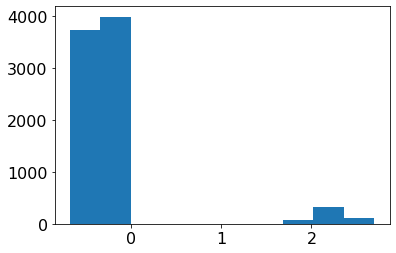

In [177]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim + (1|subj_idx)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(1|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8260	 Groups: {'subj_idx': 826.0}

Log-likelihood: -1794.225 	 AIC: 3594.450

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.426  0.653

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.430  -2.577   -2.284  0.075  0.088      0.076       0.102   
stim1          -1.354  -1.572   -1.137  0.111  0.258      0.208       0.321   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.081        0.071         0.092 -32.587    0.0  ***  
stim1        0.205        0.172         0.243 -12.197    0.0  ***  


(array([3750., 4009.,    0.,    0.,    0.,    0.,    0.,   69.,  321.,
         111.]),
 array([-0.68973961, -0.35087539, -0.01201118,  0.32685304,  0.66571726,
         1.00458147,  1.34344569,  1.68230991,  2.02117412,  2.36003834,
         2.69890256]),
 <BarContainer object of 10 artists>)

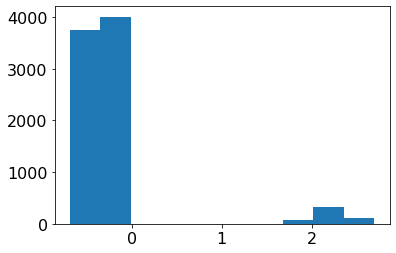

In [178]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim + (1|subj_idx)', data=fullDat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(1|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8230	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -1657.524 	 AIC: 3323.049

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.404  0.635
movie     (Intercept)  0.769  0.877

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.642  -3.426   -1.858  0.400  0.071      0.033       0.156   
stim1          -1.607  -2.732   -0.482  0.574  0.200      0.065       0.617   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.066        0.032         0.135  -6.607  0.000  ***  
stim1        0.167        0.061         0.382  -2.800  0.005   **  


(array([ 709., 6308.,  715.,    0.,    0.,   15.,  234.,  181.,   59.,
           9.]),
 array([-0.94263935, -0.52749636, -0.11235337,  0.30278962,  0.71793261,
         1.1330756 ,  1.54821859,  1.96336158,  2.37850457,  2.79364756,
         3.20879055]),
 <BarContainer object of 10 artists>)

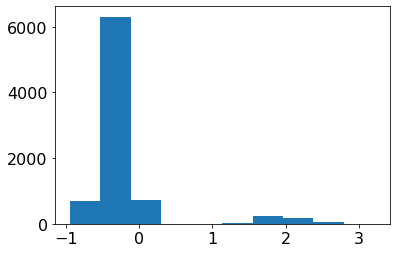

In [53]:
# certainty as a function of stimtype - REPORTED IN THE PAPER!
model = Lmer('uncertainty ~  stim +(1|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(1|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8260	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -1666.108 	 AIC: 3340.216

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.417  0.646
movie     (Intercept)  0.764  0.874

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.639  -3.421   -1.858  0.399  0.071      0.033       0.156   
stim1          -1.619  -2.742   -0.497  0.573  0.198      0.064       0.608   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.067        0.032         0.135  -6.619  0.000  ***  
stim1        0.165        0.061         0.378  -2.828  0.005   **  


(array([ 713., 5865., 1181.,    0.,    0.,   16.,  234.,  183.,   59.,
           9.]),
 array([-0.94999613, -0.53405553, -0.11811492,  0.29782569,  0.7137663 ,
         1.1297069 ,  1.54564751,  1.96158812,  2.37752873,  2.79346934,
         3.20940994]),
 <BarContainer object of 10 artists>)

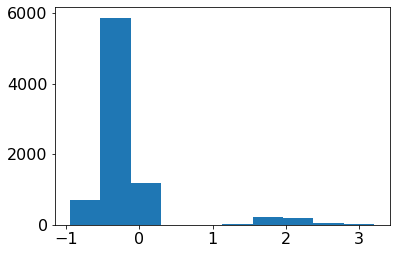

In [179]:
# same as above but for the full data (without excluding based on RT)
model = Lmer('uncertainty ~  stim +(1|subj_idx) + (1|movie)', data=fullDat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

In [187]:
# save data for trait analysis etc.
summary1.to_csv(os.path.join(file_loc,'data_for_paper','1e_S_NS_pc_uncertainResp_per_subj.csv'))
summary1_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1e_S_NS_pc_uncertainResp_per_subj_fullDat.csv'))

## Plot all subplots together

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

In [189]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [190]:
fig_save_loc = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig1_hcpbeh'

mean diff: 5.7843931416227905
Ttest_relResult(statistic=-9.955057612909297, pvalue=4.0348763675618627e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
26813.5 , 1.0623685894361655e-18 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
before: (823, 2)
after: (823, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


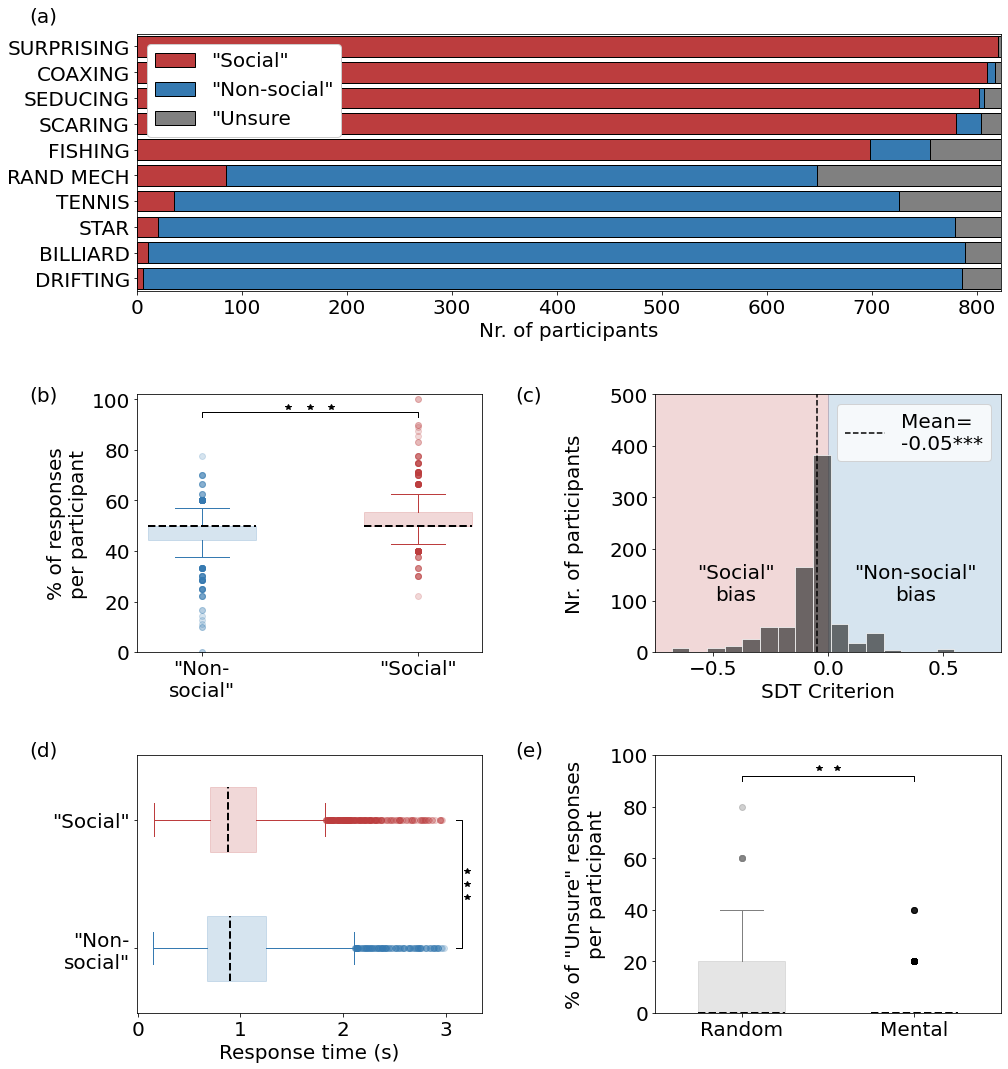

In [192]:
fig = plt.figure(1,figsize = (15,17))
ax = fig.add_subplot(311)
plot_fig_1a(ax,counts)

ax = fig.add_subplot(323)
plot_fig_1b(ax,counts_per_subj)
ax.set_xlim(-0.3,1.3)

ax = fig.add_subplot(324)
plot_fig_1c(ax,sdt_measures)

ax = fig.add_subplot(325)
plot_fig_1d(ax, p_rt)

ax = fig.add_subplot(326)
summary = 100*dat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary.shape
fig = plt.figure(1,figsize = (3,3))
summary = plot_fig_1e(ax,summary)

fig.text(0,.91,'(a)',fontsize=20)
fig.text(0,.6,'(b)',fontsize=20)
fig.text(0,.31,'(d)',fontsize=20)
fig.text(0.45,.6,'(c)',fontsize=20)
fig.text(0.45,.31,'(e)',fontsize=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)


plt.savefig(os.path.join(fig_save_loc,'Figure1.png'),dpi=300,bbox_inches='tight',facecolor='w')

mean diff: 5.839482685729659
Ttest_relResult(statistic=-10.0512171700471, pvalue=1.680706301406872e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
26834.0 , 4.435764321171681e-19 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
before: (826, 2)
after: (826, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


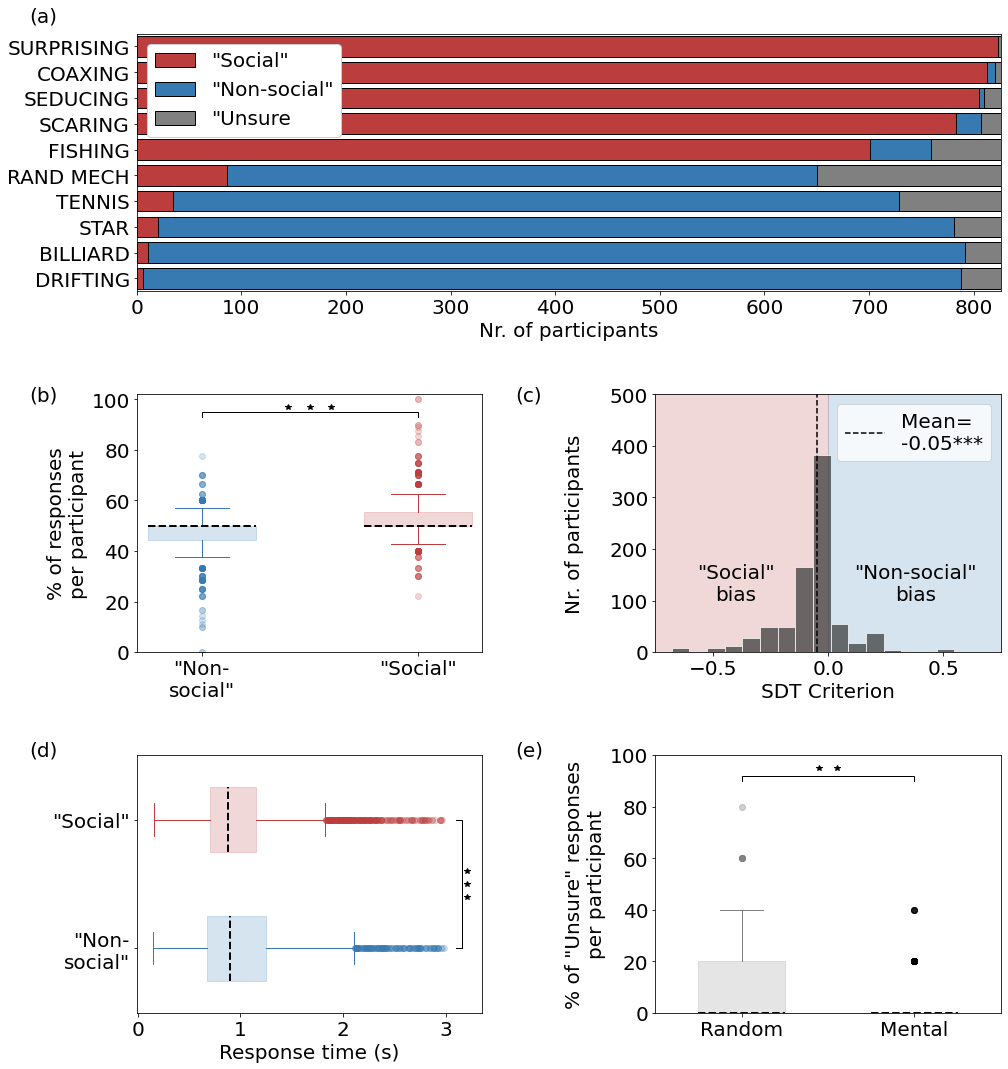

In [195]:
# full data

fig = plt.figure(1,figsize = (15,17))
ax = fig.add_subplot(311)
plot_fig_1a(ax,counts_fullDat)

ax = fig.add_subplot(323)
plot_fig_1b(ax,counts_per_subj_fullDat)
ax.set_xlim(-0.3,1.3)

ax = fig.add_subplot(324)
plot_fig_1c(ax,sdt_measures_fullDat)

ax = fig.add_subplot(325)
plot_fig_1d(ax, p_rt_fullDat)

ax = fig.add_subplot(326)
summary_fullDat = 100*fullDat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary_fullDat.shape
fig = plt.figure(1,figsize = (3,3))
summary_fullDat = plot_fig_1e(ax,summary_fullDat)

fig.text(0,.91,'(a)',fontsize=20)
fig.text(0,.6,'(b)',fontsize=20)
fig.text(0,.31,'(d)',fontsize=20)
fig.text(0.45,.6,'(c)',fontsize=20)
fig.text(0.45,.31,'(e)',fontsize=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)

plt.savefig(os.path.join(fig_save_loc,'Figure1_fullDat.png'),dpi=300,bbox_inches='tight',facecolor='w')